In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import json
import sys
import os

In [2]:

sys.path.append('../scr')

from utils_clean import filtrar_ub_mensual, partir_train_test
from utils_data import downloadTable
from utils_model import buscar_hiperparametros_arima_sarima
from utils_metrics import errorMetrics

# Importar datos de Big Query

In [3]:
queryPrices = """
SELECT * FROM `desarrollo-444913.globalPrices.prices`
"""
# Usar forceDownload=True para actualizar la tabla
df = downloadTable(queryPrices,"globalPricesTable",forceDownload=False)

Folder 'bigqueryDatabases' already exists.
Reading bigqueryDatabases\globalPricesTable.csv from local CSV.


# Preprocesamiento

In [4]:
dfUbMensual = filtrar_ub_mensual(df)

# Visualización

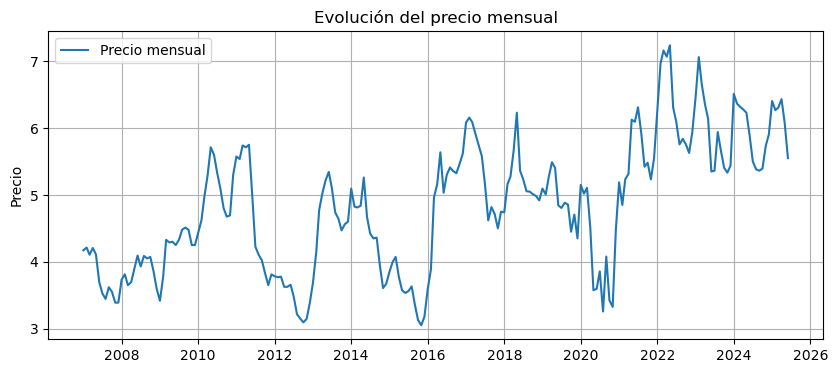

In [5]:
plt.figure(figsize=(10, 4))
plt.plot(dfUbMensual, label="Precio mensual")
plt.title("Evolución del precio mensual")
plt.ylabel("Precio")
plt.grid(True)
plt.legend()
plt.show()

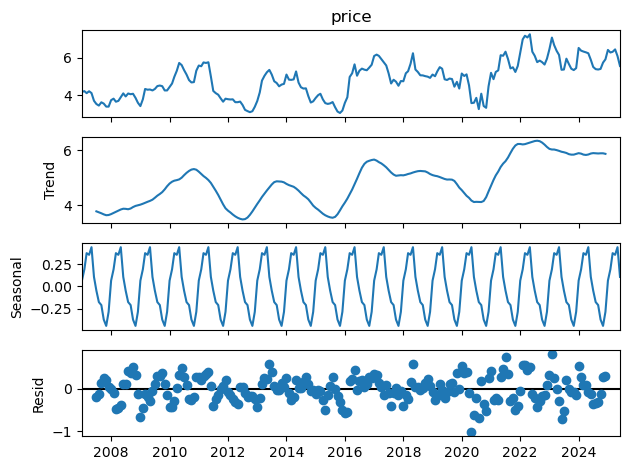

In [6]:
result = seasonal_decompose(dfUbMensual, model='additive', period=12)

# Plot the decomposition
result.plot()
plt.tight_layout()
plt.show()

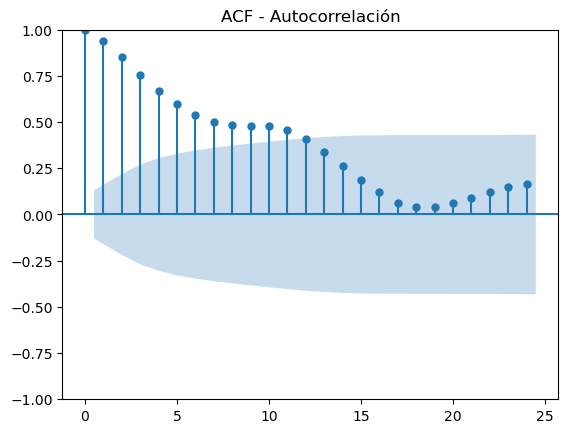

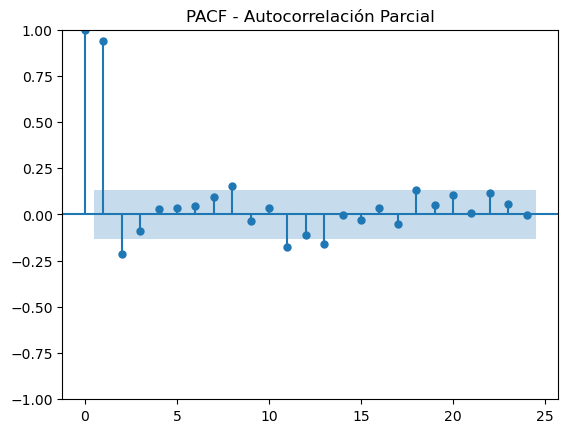

In [7]:

plot_acf(dfUbMensual, lags=24)
plt.title("ACF - Autocorrelación")
plt.show()

plot_pacf(dfUbMensual, lags=24)
plt.title("PACF - Autocorrelación Parcial")
plt.show()


In [8]:

resultado = adfuller(dfUbMensual)
valor_p = resultado[1]
print(f"p: {valor_p}")

# Interpretar el resultado
if valor_p < 0.05:
    print("La serie es estacionaria (se rechaza la hipótesis nula).")
else:
    print("La serie no es estacionaria (no se puede rechazar la hipótesis nula).")

# Como es estacionaria, no es necesario diferenciarla

p: 0.03102517498705333
La serie es estacionaria (se rechaza la hipótesis nula).


# Modelado

## Train-test split

In [9]:
# Vamos a usar hasta 2023 y testear en 2024
dfUbMensual = dfUbMensual.sort_index()
# Entrenamiento: todo hasta diciembre 2024
train = dfUbMensual.loc[:'2023-12-01']   # Ajusta el string según tu índice
# Test: enero, febrero, marzo 2025
test = dfUbMensual.loc['2024-01-01':'2024-12-01']


## Ajuste Para Seasonal Arima

In [10]:
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(train, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=138.462, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=131.857, Time=0.22 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=132.670, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=136.531, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=134.671, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=132.588, Time=0.29 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=132.357, Time=0.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=134.437, Time=0.08 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=133.808, Time=0.16 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=133.825, Time=0.22 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=132.108, Time=0.12 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=135.781, Time=0.41 sec
 ARIMA(1,1,0)(1,0,0)[12]             : AI

## Forecast horizonte de un año

In [22]:

# Informacion del log
date = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
dir_checkpoint = f"""results/Sarima_{order[0]}_{order[1]}_{order[2]}_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}_{date}_12Meses/"""
horizonte = 12

serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')
modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
pred = fitted.forecast(steps=12)
metric = errorMetrics(test.to_numpy(), pred.to_numpy())

if not os.path.exists(dir_checkpoint):
    os.makedirs(dir_checkpoint)

logDict = {"p":order[0],
"d":order[1],
"q":order[2],
"P":seasonal_order[0],
"D":seasonal_order[1],
"Q":seasonal_order[2],
"M":seasonal_order[3],
"Horizonte": horizonte}

with open(dir_checkpoint + 'log.json', 'w') as f:
    json.dump(logDict, f, indent=4)
pd.DataFrame.from_dict(metric).to_csv(str(dir_checkpoint)+'metricas.csv', index=False)
result = pd.concat([test, pred], axis=1)
result.columns = ['real', 'pred']
result.to_csv(str(dir_checkpoint)+'predicciones.csv', index=True)

## Ajuste Para Seasonal Arima with Kalman Filter adapt one step Prediction

## Arima si usa kalman filter solo que en está versión estamos haciendo update de su estado interno con las nuevas observaciones.

In [31]:
# Informacion del log
date = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
dir_checkpoint = f"""results/Sarima_{order[0]}_{order[1]}_{order[2]}_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}_{date}/"""
horizonte = 1


serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')
modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
pred = []
for i in range(len(fechas_pred)):
    if i ==0:
        pred.append(fitted.forecast(steps=1)[0])
    else:
        fitted = fitted.extend(test[i-1:i])
        pred.append(fitted.forecast(steps=1)[0])
metric = errorMetrics(test.to_numpy(), np.array(pred))

if not os.path.exists(dir_checkpoint):
    os.makedirs(dir_checkpoint)

logDict = {"p":order[0],
"d":order[1],
"q":order[2],
"P":seasonal_order[0],
"D":seasonal_order[1],
"Q":seasonal_order[2],
"M":seasonal_order[3],
"Horizonte": horizonte}

with open(dir_checkpoint + 'log.json', 'w') as f:
    json.dump(logDict, f, indent=4)
pd.DataFrame.from_dict(metric).to_csv(str(dir_checkpoint)+'metricas.csv', index=False)
# Aqui es porque  pred es una lista de predicciones, pandas
pred_series = pd.Series(pred, index=test.index)
result = pd.concat([test, pred_series], axis=1)
result.columns = ['real', 'pred']
result.to_csv(str(dir_checkpoint)+'predicciones.csv', index=True)

# Rolling predictions

In [15]:
serie_rolling = train.copy()
predicciones = []
fechas_pred = pd.date_range('2024-01-01', '2024-12-01', freq='MS')

for fecha in fechas_pred:
    modelo = ARIMA(serie_rolling, order=order,seasonal_order=seasonal_order)
    fitted = modelo.fit()
    pred = fitted.forecast(steps=1)[0]
    predicciones.append(pred)
    
    # Rolling: Si hay valor real, lo uso; si no, uso lo predicho
    if fecha in df.index:  # Hay valor real disponible (enero a mayo 2025)
        valor_a_agregar = df.loc[fecha]
    else:  # De junio a diciembre, ya no hay real
        valor_a_agregar = pred
    
    # Concatenar el valor (como pd.Series, con índice fecha)
    serie_rolling = pd.concat([serie_rolling, pd.Series([valor_a_agregar], index=[fecha])])


# Crea una lista de reales solo para las fechas disponibles
reales_disponibles = [df[fecha] if fecha in df.index else np.nan for fecha in fechas_pred]
pred_df = pd.DataFrame({'real': reales_disponibles, 'predicho': predicciones}, index=fechas_pred)
print(pred_df)

            real  predicho
2024-01-01   NaN  5.528090
2024-02-01   NaN  5.626188
2024-03-01   NaN  5.562873
2024-04-01   NaN  5.514663
2024-05-01   NaN  5.480265
2024-06-01   NaN  5.355366
2024-07-01   NaN  5.357351
2024-08-01   NaN  5.448835
2024-09-01   NaN  5.403836
2024-10-01   NaN  5.364083
2024-11-01   NaN  5.352629
2024-12-01   NaN  5.369155


# Evaluación

In [16]:
# Añade año y cuartil (trimestre)
pred_df['año'] = pred_df.index.year
pred_df['cuartil'] = pred_df.index.quarter
pred_df['cuartil_str'] = pred_df['año'].astype(str) + '-Q' + pred_df['cuartil'].astype(str)

# Calcula métricas para cada cuartil con datos reales
for cuartil in pred_df['cuartil_str'].unique():
    datos = pred_df[pred_df['cuartil_str'] == cuartil]
    mask = ~datos['real'].isna()  # Solo evalúa donde hay datos reales
    if mask.sum() > 0:
        metrics = errorMetrics(datos.loc[mask, 'real'], datos.loc[mask, 'predicho'])
        print(f"{cuartil}: {metrics}")
    else:
        print(f"{cuartil}: Sin datos reales para evaluar.")

2024-Q1: Sin datos reales para evaluar.
2024-Q2: Sin datos reales para evaluar.
2024-Q3: Sin datos reales para evaluar.
2024-Q4: Sin datos reales para evaluar.


# Ultima sección resultados de forecast con modelo entrenado hasta el final

In [17]:
modelo, order, seasonal_order, resumen = buscar_hiperparametros_arima_sarima(dfUbMensual, m=12, seasonal=True)
print(resumen)
print("Mejores (p, d, q):", order)
print("Mejores (P, D, Q, m):", seasonal_order)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=152.592, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=142.288, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=143.774, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=150.667, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=148.204, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=141.461, Time=0.44 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=118.537, Time=1.21 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.79 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=117.687, Time=1.29 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=144.647, Time=0.43 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=143.475, Time=0.13 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=116.820, Time=0.92 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=147.316, Time=0.43 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AI

In [18]:
# Informacion del log
date = pd.Timestamp.now().strftime('%Y-%m-%d_%H-%M-%S')
dir_checkpoint = f"""results2025/Sarima_{order[0]}_{order[1]}_{order[2]}_{seasonal_order[0]}_{seasonal_order[1]}_{seasonal_order[2]}_{seasonal_order[3]}_{date}_12Meses/"""
horizonte = 12

modelo = ARIMA(serie_rolling, order = order,seasonal_order = seasonal_order)
fitted = modelo.fit()
pred = fitted.forecast(steps=12)


if not os.path.exists(dir_checkpoint):
    os.makedirs(dir_checkpoint)

logDict = {"p":order[0],
"d":order[1],
"q":order[2],
"P":seasonal_order[0],
"D":seasonal_order[1],
"Q":seasonal_order[2],
"M":seasonal_order[3],
"Horizonte": horizonte}

with open(dir_checkpoint + 'log.json', 'w') as f:
    json.dump(logDict, f, indent=4)
pred.to_csv(str(dir_checkpoint)+'predicción.csv', index=True)
